# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [5]:
music21.environment.get('musicxmlPath')

PosixPath('/usr/bin/musescore')

In [6]:
path = Path('data/midi/v6/midi_transcribe/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hoo

In [7]:
model_path = 'fastai/txl/hook/1_ep20_run1_best'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [8]:
bs=8
bptt=500

In [9]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 17, ..., 43, 29, 57, 29]))

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

### Load Learner

In [11]:
cuda_enabled = torch.cuda.is_available()

In [12]:
tfmerXL_lm_config['ctx_len'] = 512
tfmerXL_lm_config['mem_len'] = 512

In [14]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:224: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [15]:
learn = learn.load(model_path)

## Done

In [ ]:
# learn.show_results(rows=5, max_len=25)

In [32]:
# idx = 3
# idx = 8
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)
# file = files[idx]; file
file = np.random.choice(files); file

PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/t/the-decemberists/culling-of-the-fold/intro_key.txt')

In [33]:
# best = Path('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/e/elton-john/tiny-dancer/pre-chorus_key.txt')

In [34]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(176,
 '|| t0 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nF5 t4 || t3 nE5 t4 || t1 nC3 t4')

In [35]:
ns = str2stream(seed)
ns.show('midi')

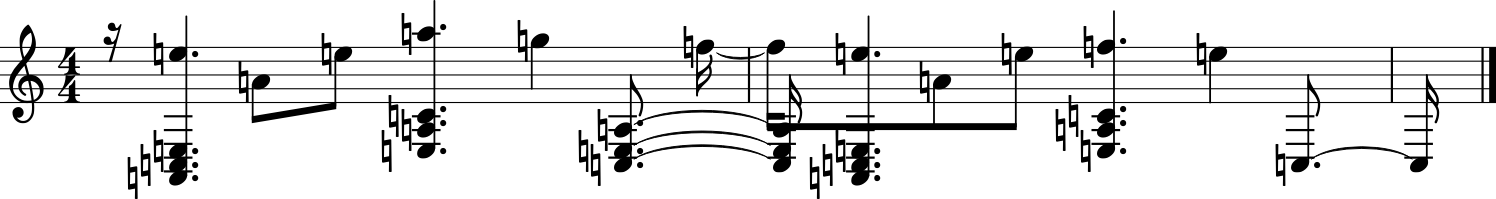

In [36]:
ns = str2stream(seed).show()

In [37]:
seed

'|| t0 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nF5 t4 || t3 nE5 t4 || t1 nC3 t4'

In [38]:
# full song
str2stream(' '.join(notes)).show('midi')

### Predictions without beam search

In [46]:
pred_out = learn.predict(seed, n_words=150, temperature=2); pred_out

'|| t0 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nF5 t4 || t3 nE5 t4 || t1 nC3 t4 nE3 t8 nF3 t12 nA3 t12 nA4 t24 || t7 nG4 t24 nE5 t24 || t3 nG6 t16 nA6 t16 || t15 nD3 t16 nE-3 t28 nE-3 t16 nE3 t8 nF3 t12 nF3 t12 nA3 t11 nA3 nE-6 t28 || t368 t128 || nD2 t8 nB2 t8 nE4 t16 nE5 t21 nG5 t32 || t6 t285 t8 t199 t4 nC#2 t172 || t4 nC#8 t8 xxbos || t0 nG6 t22 || t21 nF#6 t22 || t150 t10 t228 t66 t118 t302 t94 t168 t181 t347 t30 t292 t92 t183 t274 nF#5 nC#8 t150 t282 t6 nE-8 t182 t99 || t198 t102 t176 T267 t30 nE9 t32 t320 nC#6 t86 nG#6 nD7 t255 t142 t300 t38 nC#9 t162 t138 t30 nE3 t260 nF#5 t188 t58 t82 t38 nF6 t294 t62 t89 t170 t38 t204 t30 t130 t220 t125 t360 t96 t70 t209 t229 t1 t112 nF6 t134 nE-6 t83 t142'

In [40]:
pred_out = learn.predict_old(seed, n_words=150); pred_out

'|| t0 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nF5 t4 || t3 nE5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nA4 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nF5 t4 || t3 nE5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nA4 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2 || t1 nA4 t2 || t1 nE5 t2 || t1 nE3 t6 nA3 t6 nC4 t6 nA5 t4 || t3 nG5 t4 || t1 nC3 t4 nE3 t4 nA3 t4 || t1 nF5 t2 || t1 nA2 t6 nC3 t6 nE3 t6 nE5 t2'

In [47]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'nE3 t8 nF3 t12 nA3 t12 nA4 t24 || t7 nG4 t24 nE5 t24 || t3 nG6 t16 nA6 t16 || t15 nD3 t16 nE-3 t28 nE-3 t16 nE3 t8 nF3 t12 nF3 t12 nA3 t11 nA3 nE-6 t28 || t368 t128 || nD2 t8 nB2 t8 nE4 t16 nE5 t21 nG5 t32 || t6 t285 t8 t199 t4 nC#2 t172 || t4 nC#8 t8 xxbos || t0 nG6 t22 || t21 nF#6 t22 || t150 t10 t228 t66 t118 t302 t94 t168 t181 t347 t30 t292 t92 t183 t274 nF#5 nC#8 t150 t282 t6 nE-8 t182 t99 || t198 t102 t176 T267 t30 nE9 t32 t320 nC#6 t86 nG#6 nD7 t255 t142 t300 t38 nC#9 t162 t138 t30 nE3 t260 nF#5 t188 t58 t82 t38 nF6 t294 t62 t89 t170 t38 t204 t30 t130 t220 t125 t360 t96 t70 t209 t229 t1 t112 nF6 t134 nE-6 t83 t142'

In [48]:
ns = str2stream(pred_only)
ns.show('midi')

't'
't'
't'


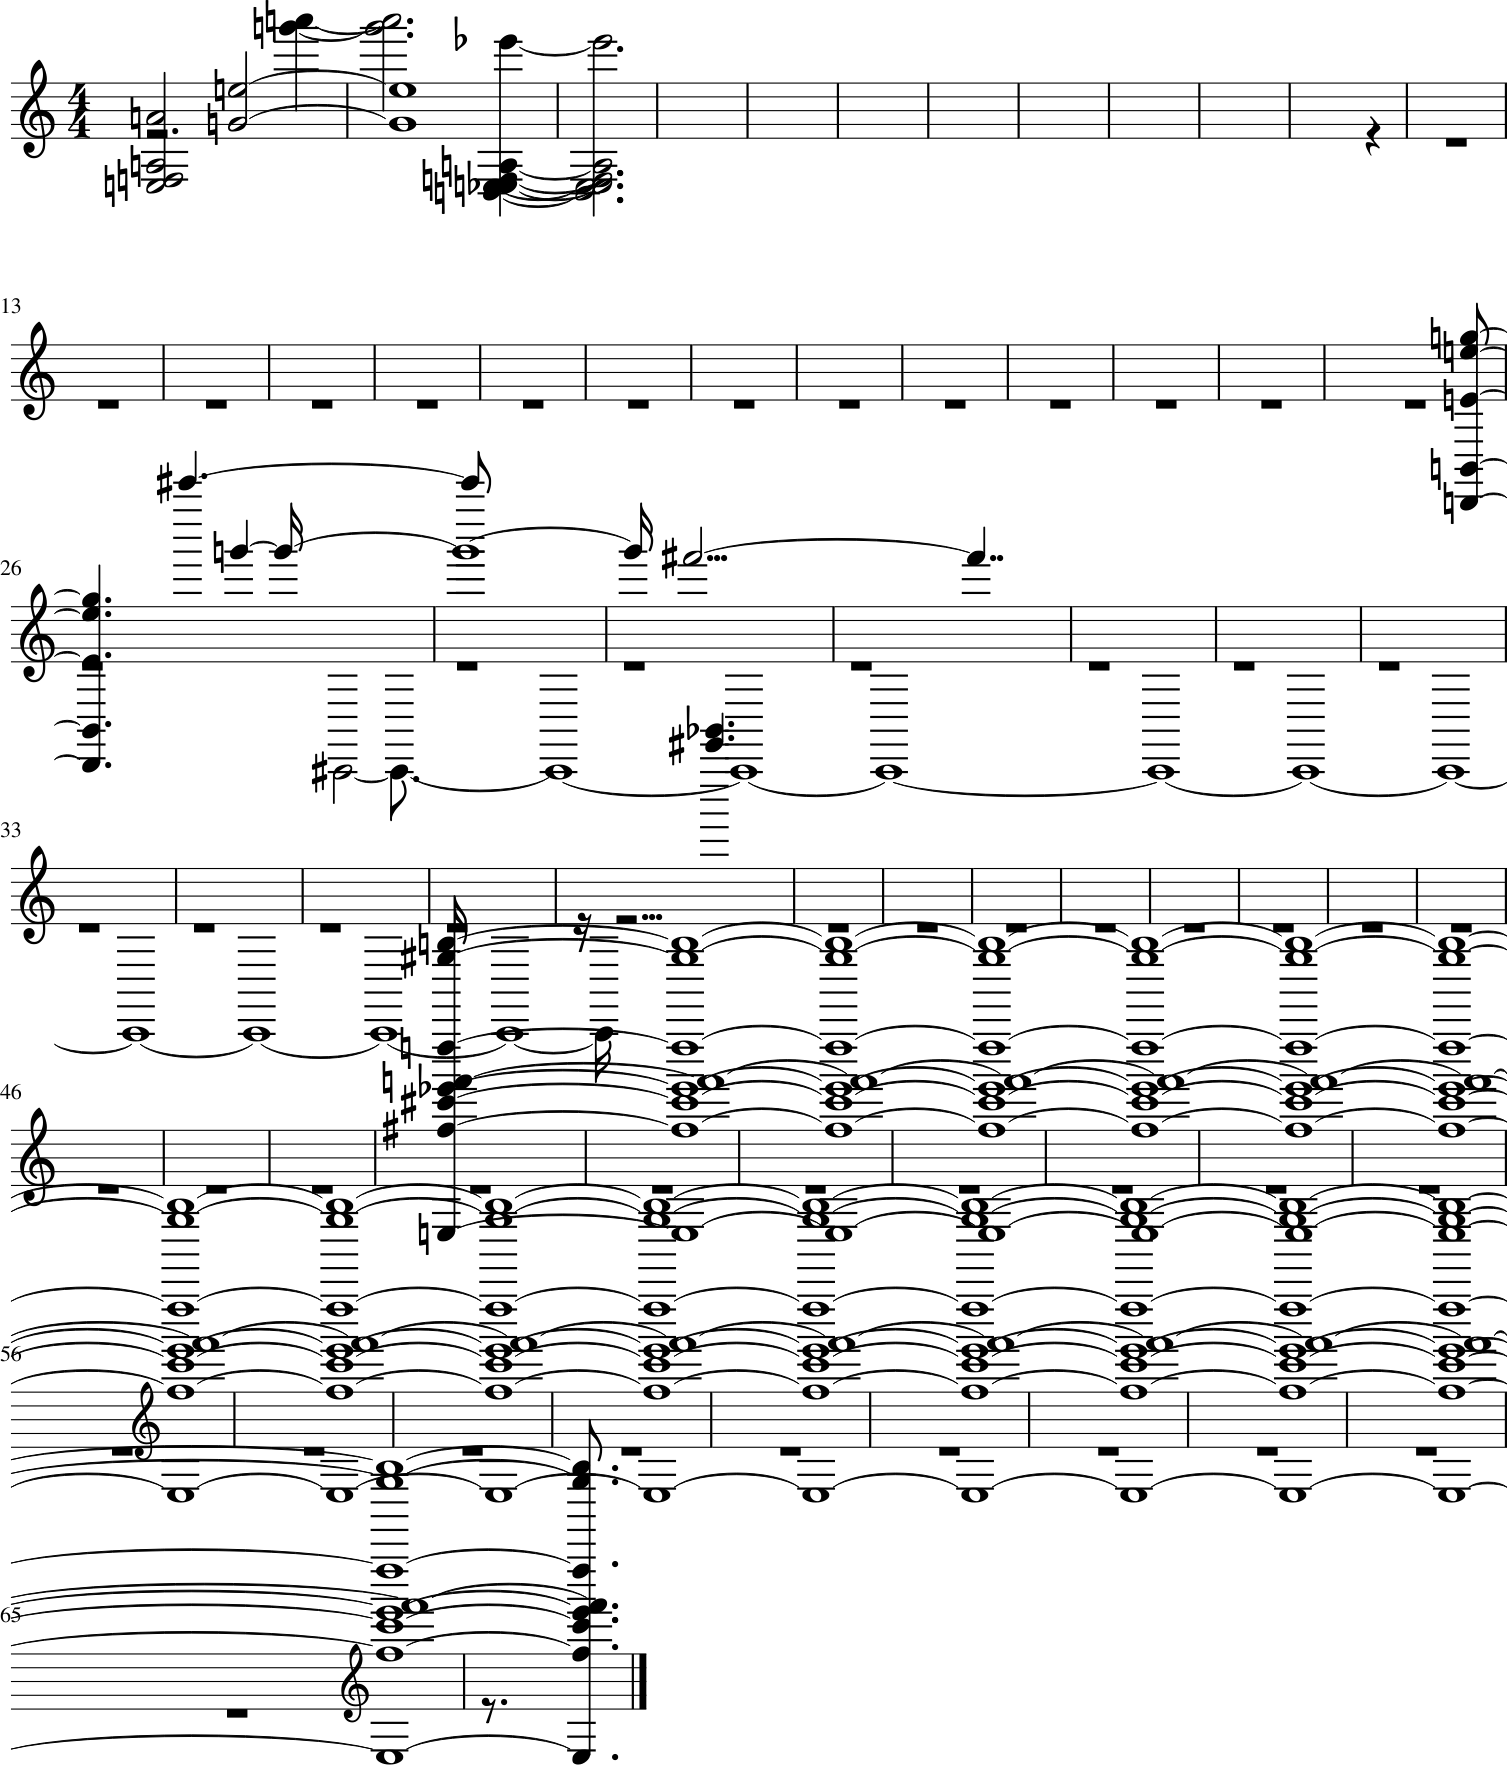

In [49]:
ns.show()

In [50]:
str2seq(pred_only)

't'
't'
't'


[[E3t8, F3t12, A3t12, A4t24],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [G4t24, E5t24],
 [],
 [],
 [],
 [G6t16, A6t16],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [D3t16, E-3t28, E-3t16, E3t8, F3t12, F3t12, A3t11, E-6t28],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [51]:
ns = str2stream(pred_out)
ns.show('midi')

't'
't'
't'


### Fastai beam search

In [117]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410])]

In [118]:
pred_out = learn.beam_search(seed, n_words=200); pred_out

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 10 and 1 in dimension 0 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:83

In [40]:
xb,yb = learn.data.one_item(seed)

In [41]:
xb.shape

torch.Size([1, 80])

### Beam search

In [67]:
from beam_search import *

In [74]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'nB3 t16 nB4 t4 || t3 nE4 t10 || t9 nA4 t1 || t0 nB4 t1  nB3 t16 nB4 t4 || t3 nE4 t10 || t9 nA4 t1 || t0 nB4 t1  nB3 t16 nB4 t4 || t3 nE4 t10'

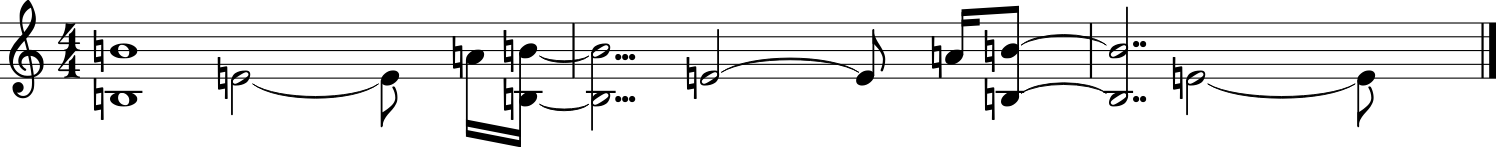

In [75]:
ns_only = str2stream(pred_beam_only).show()

In [76]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

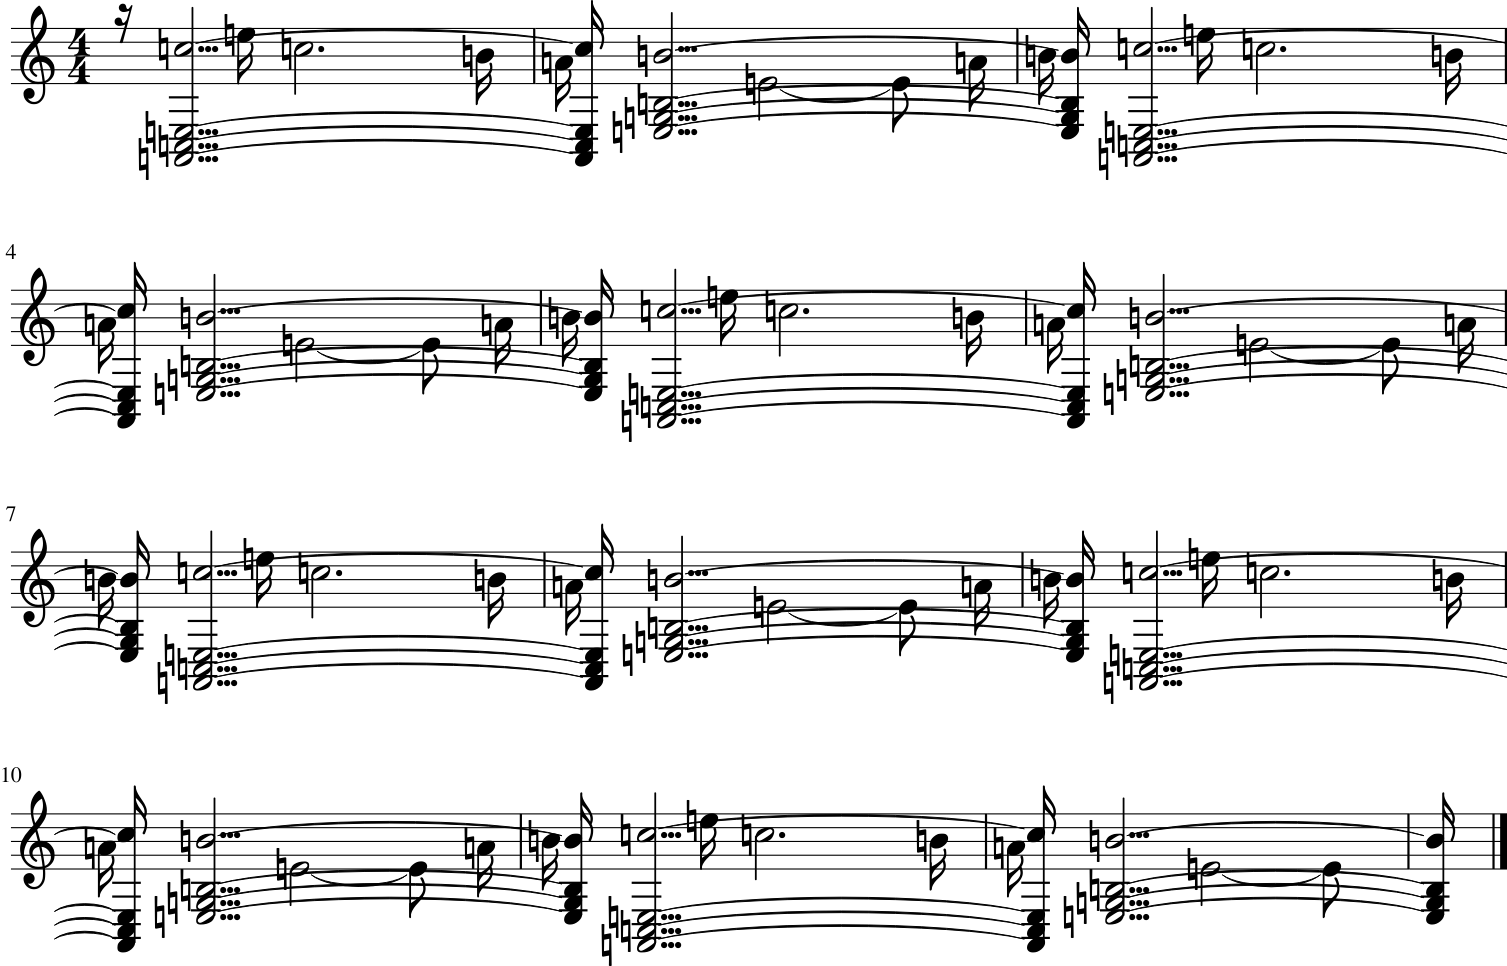

In [77]:
ns = str2stream(pred_beam).show()

In [72]:
ns = str2stream(pred_beam)
ns.show('midi')